In [1]:
%load_ext autoreload
%autoreload 2

from cadet_imports import *

In [2]:
import my_cadet_utils as cad_utils
import parameter_correlations as corr
import exploration_helper as explor

from matplotlib import cm
import gc

from scipy import interpolate, optimize

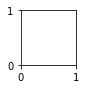

In [3]:
fig, ax = explor.instantiate_fig(x=1, y=1)

# Constants, etc.

In [4]:
def as_si(x, ndp):
    s = '{x:0.{ndp:d}e}'.format(x=x, ndp=ndp)
    m, e = s.split('e')
    return r'{m:s}\times 10^{{{e:d}}}'.format(m=m, e=int(e))

In [5]:
image_folder = Path().absolute() / 'images_manuscript'

In [6]:
v_col = 0.042 * np.pi/4 * (0.5**2) * 1e-4

eps_c = 0.49
eps_p = 0.4
eps_t = eps_c + eps_p*(1.0 - eps_c)

mass = 50

# Breakthrough profiles at different load concentrations

In [7]:
results_folder = Path().absolute() / 'sim_results_updated_PREP_2021'
sims = os.listdir(results_folder)
sims.sort()

In [8]:
# # These plots aren't shown below - it takes a lot of RAM to load the simulation 
# # results for the lower load concentrations 

# c_load_vals = np.array([2.0e-5, 2.0e-4, 2.0e-3, 2.0e-2, 2.0e-1])

# for c_val in c_load_vals:
#     fig, ax = explor.instantiate_fig(x=10, y=6)
#     ax.set_xlabel('CV')
#     ax.set_ylabel(r'c$_{out}$/c$_{load}$')
    
#     files = [i for i in sims if f'{c_val:.1e}' in i]
#     for f in files:
#         c_load, this_dp, ka, q_max, kd, keq, t, c_out, fVolum, Ds, d_part, l_col =\
#         explor.get_sim_results(results_folder, f, True)

#         if c_load == c_val:
#             ax.plot(t*fVolum/v_col, c_out/c_load)
        
#     ax.set_xscale('log')
#     ax.set_xlim(0.1, 5e4)
#     explor.set_layout(fig, ax)
# #     fig.savefig(os.path.join(image_folder, f'breakthrough_curves_c_{c_val*mass*1e3:.0f}_ug_ml.png'), dpi=150)
# #     fig.savefig(os.path.join(image_folder, f'breakthrough_curves_c_{c_val*mass*1e3:.0f}_ug_ml.pdf'))
    
#     fig.clf()
#     plt.close()
#     gc.collect()

## Combined

In [9]:
# # It takes a lot of RAM to load the simulation results for the lower load concentrations 

# fig, ax = plt.subplots(3, 1, sharex=True, sharey=True)
# fig.set_size_inches(10, 18)
# ax[2].set_xlabel('CV')
# ax[0].set_xscale('log')
# ax[0].set_xlim(0.1, 5e4)
# for j in range(3):
#     ax[j].set_ylabel(r'c$_{out}$/c$_{load}$')
#     ax[j].tick_params(axis='both', direction='in', length=8, bottom=True, top=True, left=True, right=True)
#     ax[j].tick_params(axis='both', which='minor', direction='in', length=4, bottom=True, top=True, left=True, right=True)

# for j, c_val in enumerate([2.0e-1, 2.0e-3, 2.0e-5]):
#     label=fr'c = 10$^{{{np.log10(c_val*mass):.0f}}}$ mg/ml'
#     ax[j].text(0.98, 0.07, label, horizontalalignment='right', transform=ax[j].transAxes)
    
#     files = [i for i in sims if f'{c_val:.1e}' in i]
#     for f in files:
#         c_load, this_dp, ka, q_max, kd, keq, t, c_out, fVolum, Ds, d_part, l_col = explor.get_sim_results(results_folder, f, True)
#         if c_load == c_val:
#             ax[j].plot(t*fVolum/v_col, c_out/c_load)

# plt.subplots_adjust(hspace=0.05)
# fig.savefig('./images_manuscript/breakthrough_curves_stacked.pdf', bbox_inches='tight')
# # fig.savefig('./images_manuscript/breakthrough_curves_stacked.png', dpi=300, bbox_inches='tight')

# # fig.clf()
# # plt.close()
# # gc.collect()

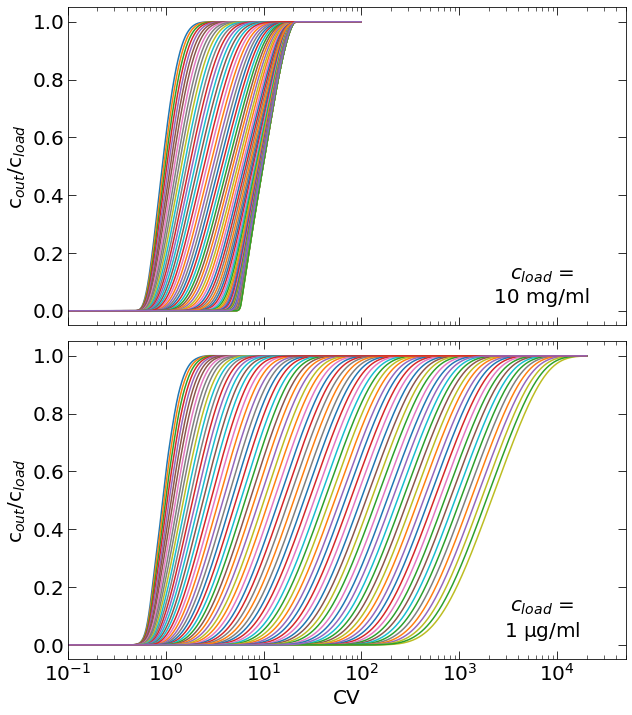

In [10]:
# It takes a lot of RAM to load the simulation results for the lower load concentrations 

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True)
fig.set_size_inches(10, 12)
ax[1].set_xlabel('CV')
ax[0].set_xscale('log')
ax[0].set_xlim(0.1, 5e4)
for j in range(2):
    ax[j].set_ylabel(r'c$_{out}$/c$_{load}$')
    ax[j].tick_params(axis='both', direction='in', length=8, bottom=True, top=True, left=True, right=True)
    ax[j].tick_params(axis='both', which='minor', direction='in', length=4, bottom=True, top=True, left=True, right=True)

for j, c_val in enumerate([2.0e-1, 2.0e-5]):
    if j == 0:
        label=r'$c_{{load}}$ =' + '\n' + '10 mg/ml'
    elif j == 1:
        label=r'$c_{{load}}$ =' + '\n' + r'1 $\rm{\mu}$g/ml'
    ax[j].text(0.85, 0.07, label, horizontalalignment='center', transform=ax[j].transAxes)
    
    files = [i for i in sims if f'{c_val:.1e}' in i]
    for f in files:
        c_load, this_dp, ka, q_max, kd, keq, t, c_out, fVolum, Ds, d_part, l_col = explor.get_sim_results(results_folder, f, True)
        if c_load == c_val:
            ax[j].plot(t*fVolum/v_col, c_out/c_load)

plt.subplots_adjust(hspace=0.05)
fig.savefig('./images_manuscript/breakthrough_curves_stacked_2.pdf', bbox_inches='tight')

# fig.clf()
# plt.close()
# gc.collect()

# $CV_{break}$ vs. $K_{eq}$ at different $c_{load}$

In [11]:
get_cv_ideal = lambda eps_t, Keq: eps_t + Keq*(1.0 - eps_t)

def solve_time(time, frac, f):
    return f(time) - frac

def get_sim_data_keq(args):               
    file_name, results_folder = args
    c_load, Dp, ka, q_max, kd, keq, t, c_out, fVolum, Ds, d_part, l_col =\
    explor.get_sim_results(results_folder, file_name)
    these_res = [c_load, fVolum, Dp, d_part, l_col, Ds, keq, q_max]
    
    fracs = np.arange(0.01, 0.81, 0.01)
    d_col = 0.5e-2
    area_col = np.pi/4 * d_col**2
    v_col = area_col * l_col
    norm_c = c_out/c_load
    f = interpolate.interp1d(t, norm_c, kind='cubic')

    for frac in fracs:
        idx = np.searchsorted(norm_c, frac, side="left")
        t_guess = t[idx]
        ftime = optimize.fsolve(solve_time, t_guess, args=(frac, f))[0]
        v_break  = ftime * fVolum
        cv_break = v_break/v_col
        these_res.append(cv_break)
    return these_res

def get_t_saturation(c_load, q_max, fVolumetric):
    return v_col*(1-eps_t)*q_max/fVolumetric/c_load

In [12]:
results_folder = Path().absolute() / 'sim_results_updated_PREP_2021'
sims = os.listdir(results_folder)
sims.sort()

In [13]:
results = []
for s in sims:
    args = (s, results_folder)
    results.append(get_sim_data_keq(args))
    
fracs = np.arange(0.01, 0.81, 0.01)
columns = ['c_load', 'fVolum', 'Dp', 'd_part', 'l_col', 'Ds', 'keq', 'q_max'] + [f'{i:.2f}' for i in fracs]
df = pd.DataFrame(np.array(results), columns=columns)

fVolum = df.fVolum.mean() # all the same
q_max  = df.q_max.mean()

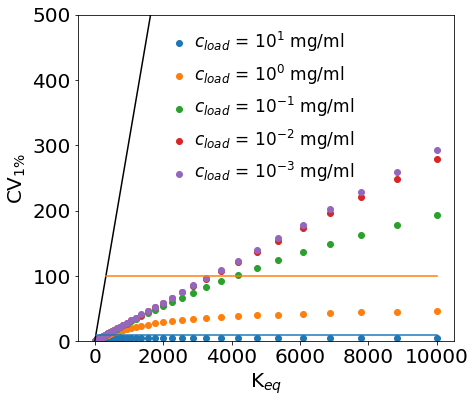

In [19]:
fig, ax = explor.instantiate_fig()
ax.set_ylabel(r'CV$_{1\%}$')
ax.set_xlabel(r'K$_{eq}$')

keq_vals = np.logspace(np.log10(min(df['keq'])), np.log10(max(df['keq'])), 5000)
cv_ideal  = [get_cv_ideal(eps_t, keq) for keq in keq_vals]
ax.plot(keq_vals, cv_ideal, color='black')

c_load_vals = np.array([2.0e-5, 2.0e-4, 2.0e-3, 2.0e-2, 2.0e-1])
c_load_vals = c_load_vals[::-1]

for c_val in c_load_vals:
    df_temp = df[df['c_load'] == c_val].copy()
    df_temp.sort_values(by=['keq'], inplace=True)
    df_temp.reset_index(inplace=True, drop=True)

    ax.scatter(df_temp['keq'], df_temp['0.01'], label=fr'$c_{{load}}$ = 10$^{{{np.log10(c_val*mass):.0f}}}$ mg/ml')
      
    keq_cross = explor.get_keq_tr_tsat(q_max, c_val)
    if keq_cross < max(df['keq']):
        cv_sat = get_t_saturation(c_val, q_max, fVolum)*fVolum/v_col
        ax.plot([keq_cross, max(df['keq'])], [cv_sat, cv_sat]) 

        
# ax.set_xscale('log')
# ax.set_yscale('log')
# explor.set_layout(fig, ax, legend=True, fontsize=17)
# fig.savefig(os.path.join(image_folder, f'cv_1_percent_vs_Keq_log.png'), dpi=150)
# fig.savefig(os.path.join(image_folder, f'cv_1_percent_vs_Keq_log.pdf'))

ax.set_ylim(0, 500)
explor.set_layout(fig, ax)
ax.legend(fontsize=17, loc='best', handlelength=0.2, frameon=False)
# fig.savefig(os.path.join(image_folder, f'cv_1_percent_vs_Keq.png'), dpi=150)
fig.savefig(os.path.join(image_folder, f'cv_1_percent_vs_Keq.pdf'))

# ax.set_ylim(0, 300)
# explor.set_layout(fig, ax)
# fig.savefig(os.path.join(image_folder, f'cv_1_percent_vs_Keq_zoomed.png'), dpi=150)
# fig.savefig(os.path.join(image_folder, f'cv_1_percent_vs_Keq_zoomed.pdf'))

# Breakthrough volume correlation

In [20]:
df_p = pd.read_csv('./updated_discretization_eps_p.csv')

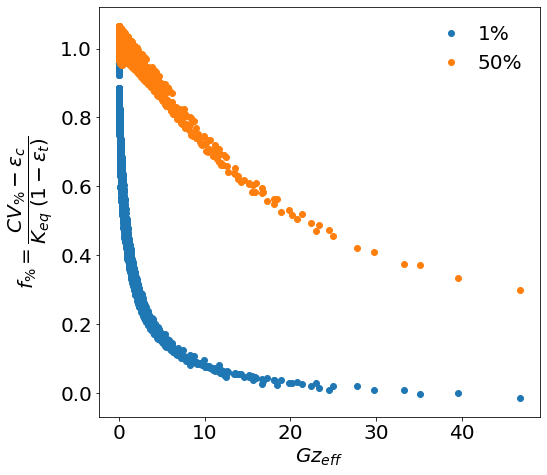

In [21]:
fig, ax = explor.instantiate_fig(8, 7)
ax.set_ylabel(r'$f_{\%} = \dfrac{CV_{\%} - \epsilon_c}{K_{eq} \; (1 - \epsilon_t)}$', fontsize=20)
ax.set_xlabel(r'$Gz_{eff}$', fontsize=20)

ax.plot(df_p['new_x'], (df_p['0.01']-eps_c)/((1.0-eps_t)*df_p['keq']), 'o', label='1%')
ax.plot(df_p['new_x'], (df_p['0.50']-eps_c)/((1.0-eps_t)*df_p['keq']), 'o', label='50%')

explor.set_layout(fig, ax, legend=True)
# fig.savefig(os.path.join(image_folder, f'correlation_breakthrough_volume.png'), dpi=300)
# fig.savefig(os.path.join(image_folder, f'correlation_breakthrough_volume.pdf'))

In [24]:
# fig, ax = explor.instantiate_fig(8, 7)
# ax.set_ylabel(r'$f_{\%} = \dfrac{CV_{\%} - \epsilon_t}{K_{eq} \; (1 - \epsilon_t)}$', fontsize=20)
# ax.set_xlabel(r'$\dfrac{v \; d_{part}^2}{D_{eff} \; L_{col}}$', fontsize=20)

# ax.plot(df_p['new_x'], (df_p['0.01']-eps_t)/((1.0-eps_t)*df_p['keq']), 'o', label='1%')
# ax.plot(df_p['new_x'], (df_p['0.50']-eps_t)/((1.0-eps_t)*df_p['keq']), 'o', label='50%')

# explor.set_layout(fig, ax, legend=True)
# fig.savefig(os.path.join(image_folder, f'correlation_breakthrough_volume_eps_t.png'), dpi=300)
# # fig.savefig(os.path.join(image_folder, f'correlation_breakthrough_volume.pdf'))

In [22]:
# fig, ax = explor.instantiate_fig(8, 7)
# ax.set_ylabel(r'$\frac{CV_{\%} - \epsilon_c}{K_{eq} \; (1 - \epsilon_t)}$', fontsize=26)
# ax.set_xlabel(r'$\frac{v \; d_{part}^2}{D_{eff} \; L_{col}}$', fontsize=26)

# ax.plot(df_p['new_x'], (df_p['0.01']-eps_c)/((1.0-eps_t)*df_p['keq']), 'o', label='1%')
# ax.plot(df_p['new_x'], (df_p['0.10']-eps_c)/((1.0-eps_t)*df_p['keq']), 'o', label='10%')
# ax.plot(df_p['new_x'], (df_p['0.50']-eps_c)/((1.0-eps_t)*df_p['keq']), 'o', label='50%')

# explor.set_layout(fig, ax, legend=True)
# # fig.savefig(os.path.join(image_folder, f'correlation_breakthrough_volume.png'), dpi=150)
# # fig.savefig(os.path.join(image_folder, f'correlation_breakthrough_volume.pdf'))

In [23]:
# fig, ax = explor.instantiate_fig(8, 7)
# ax.set_ylabel(r'$f_{\%}$', fontsize=25, rotation=0, labelpad=20)
# ax.set_xlabel(r'$Gz_{eff}$', fontsize=25)

# ax.plot(df_p['new_x'], (df_p['0.01']-eps_c)/((1.0-eps_t)*df_p['keq']), 'o', label='1%')
# ax.plot(df_p['new_x'], (df_p['0.50']-eps_c)/((1.0-eps_t)*df_p['keq']), 'o', label='50%')

# explor.set_layout(fig, ax, legend=True, fontsize=25)
# fig.savefig(os.path.join(image_folder, f'correlation_breakthrough_volume_fourth_year_talks.png'), dpi=300)


# Problematic $K_{eq}$

In [22]:
eps_c = 0.49
eps_p = 0.4
eps_t = eps_c + eps_p*(1.0 - eps_c)

mass       = 50
cap_mg     = 100 # [mg/ml column]
q_m_fac    = cap_mg/(1.0-eps_t)
q_max      = q_m_fac/mass # [mol m-3 resin]

d_col = 0.5e-2
area_col = np.pi/4 * d_col**2

a_pnas, b_pnas = (1.6598739258839034e-12, -0.23974534290342786)

In [23]:
df = pd.read_csv('./updated_discretization_eps_p.csv')

df.sort_values(by='new_x', inplace=True)
spl = interpolate.UnivariateSpline(df['new_x'], (df['0.01']-eps_c)/((1.0-eps_t)*df['keq']))
spl.set_smoothing_factor(1.5)

x_vals = np.linspace(df.new_x.min(), df.new_x.max())

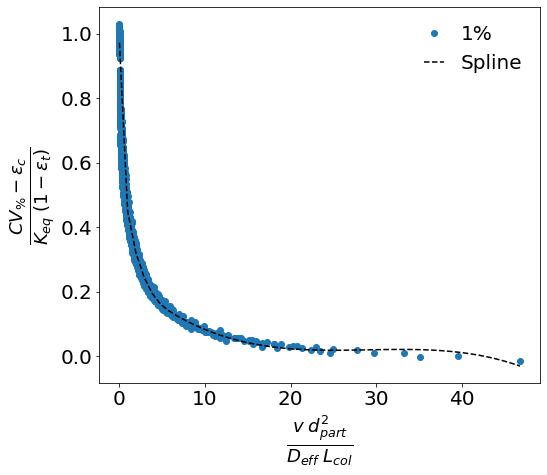

In [24]:
fig, ax = explor.instantiate_fig(8, 7)
ax.set_ylabel(r'$\frac{CV_{\%} - \epsilon_c}{K_{eq} \; (1 - \epsilon_t)}$', fontsize=26)
ax.set_xlabel(r'$\frac{v \; d_{part}^2}{D_{eff} \; L_{col}}$', fontsize=26)

ax.plot(df['new_x'], (df['0.01']-eps_c)/((1.0-eps_t)*df['keq']), 'o', label='1%')
ax.plot(x_vals, spl(x_vals), '--', color='black', label='Spline')
# ax.plot(df['new_x'], (df['0.50']-eps_c)/((1.0-eps_t)*df['keq']), 'o', label='50%')

explor.set_layout(fig, ax, legend=True)
# fig.savefig('./images_updated_discretization/correlation_1_percent_spline.png', dpi=200)

Specify new parameters, estimate Keq, and ensure the solver is converging

In [25]:
def get_error(keq, l_col, d_part, eps_c, eps_p, u, Dp, a_pnas, b_pnas, cv_load):
    Ds = explor.get_ds(keq, a_pnas, b_pnas)
    Deff = Dp + (1.0 - eps_p)/eps_p * keq * Ds
    
    v = u/(3600 * 100)/eps_c
    x = v * d_part**2 / (Deff * l_col)
    
    eps_t = eps_c + eps_p*(1.0 - eps_c)
    rhs = eps_c + keq * (1.0 - eps_t) * spl(x)
    return cv_load - rhs

In [26]:
l_col = 20e-2
d_part = 50e-6

eps_c = 0.35
eps_p = 0.5
eps_t = eps_c + eps_p*(1.0 - eps_c)

u = 200 # cm/h

Dp = 1.0e-11
a_pnas, b_pnas = (1.6598739258839034e-12, -0.23974534290342786)

cv_load = 50

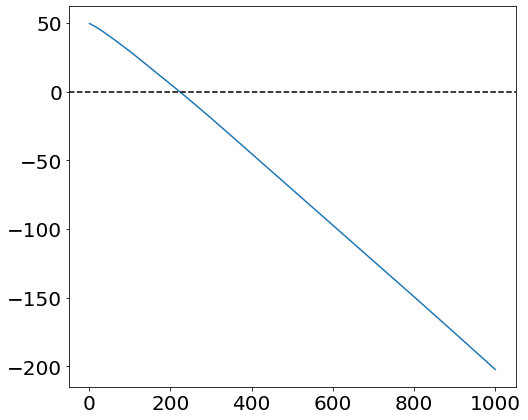

In [27]:
keq_vals = np.linspace(1, 1000, 1000)
errors = [get_error(keq, l_col, d_part, eps_c, eps_p, u, Dp, a_pnas, b_pnas, cv_load) for keq in keq_vals]
fig, ax = explor.instantiate_fig(8, 7)
ax.plot(keq_vals, errors)
ax.axhline(0, linestyle='--', color='black')

In [28]:
args=(l_col, d_part, eps_c, eps_p, u, Dp, a_pnas, b_pnas, cv_load)
res = optimize.root(get_error, x0=200, args=args)
res

    fjac: array([[-1.]])
     fun: array([-2.13162821e-14])
 message: 'The solution converged.'
    nfev: 6
     qtf: array([-1.24703874e-08])
       r: array([0.24370852])
  status: 1
 success: True
       x: array([223.05021816])

Plot the problematic Keq/k' over CV_load

In [29]:
def get_kprime(keq, eps_t):
    return (1.0 - eps_t)/eps_t * keq

In [30]:
cv_vals = np.linspace(1, 300, 300)
keq_vals = []

for cv in cv_vals:
    args=(l_col, d_part, eps_c, eps_p, u, Dp, a_pnas, b_pnas, cv)
    res = optimize.root(get_error, x0=500, args=args)
    assert res.success
    keq_vals.append(res.x[0])

kprime_vals = [get_kprime(keq, eps_t) for keq in keq_vals]

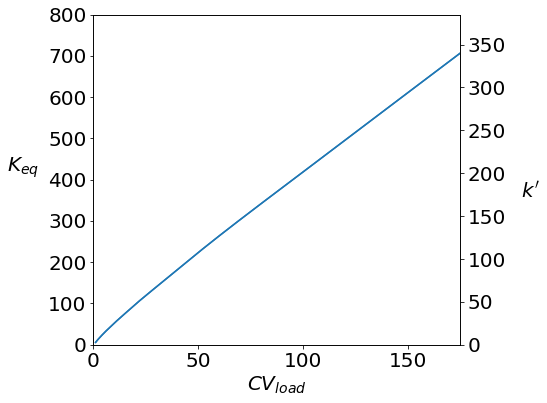

In [40]:
fig, ax = explor.instantiate_fig(8, 6)
ax.set_xlabel(r'$CV_{load}$')
ax.set_ylabel(r'$K_{eq}$', rotation=0, labelpad=25)
ax1 = ax.twinx()
ax1.set_ylabel('$k\'$', rotation=0, labelpad=25)

ax.plot(cv_vals, keq_vals)
ax1.plot(cv_vals, kprime_vals)

ax.set_xlim(0, 175)
keq_min, keq_max = 0, 800
ax.set_ylim(keq_min, keq_max)
ax1.set_ylim(get_kprime(keq_min, eps_t), get_kprime(keq_max, eps_t))

explor.set_layout(fig, ax)
fig.savefig(os.path.join(image_folder, f'problematic_Keq.png'), dpi=300)
fig.savefig(os.path.join(image_folder, f'problematic_Keq.pdf'))

# Breakthrough profiles
- From simulations with different transport and geometric parameters (with updated discretization)
- I previously wrote Nevermind - the correlation variable depends on $K_{eq}$ :)
- However, I'm plotting a year later on 2023-01-21 for having the visual comparison with experimental results that uses $Gz_{eff}$

In [88]:
def get_sim_data_4(args):               
    results_folder, file_name = args
    c_load, Dp, ka, q_max, kd, keq, t, c_out, fVolum, Ds, d_part, l_col =\
    explor.get_sim_results(results_folder, file_name)
    
    d_col = 0.5e-2
    area_col = np.pi/4 * d_col**2
    v_col = area_col * l_col
    norm_c = c_out/c_load
    
    v = fVolum/(area_col * eps_c)
    Deff = Dp + (1.0 - eps_p)/eps_p * keq * Ds
    gz = v * d_part**2 / (Deff * l_col)
        
    df_results = pd.DataFrame(np.array([t, c_out/c_load]).transpose(), columns=['time_s', 'c_normal'])
    df_results['CV'] = fVolum*df_results['time_s']/v_col
    
    vals = [gz, keq, Deff, v, d_part, l_col, Dp]
    return vals, df_results

In [89]:
results_folder = Path().absolute() / 'sim_results_updated_discretization'

files = os.listdir('./sim_results_updated_discretization/')
keq_strings = [file[file.find('keq')+4:file.find('fVolum')-1] for file in files]
keq_strings = list(set(keq_strings))
keq_strings.sort()

In [90]:
files_1 = [(results_folder, file) for file in files if '1.00e+01' in file]
files_3 = [(results_folder, file) for file in files if '1.00e+03' in file]
res_1 = {}
res_3 = {}
params_1 = []
params_3 = []

for f in files_1:
    vals, df = get_sim_data_4(f)
    res_1[vals[0]] = df
    params_1.append(vals)
    
for f in files_3:
    vals, df = get_sim_data_4(f)
    res_3[vals[0]] = df
    params_3.append(vals)
    
x1 = list(res_1.keys())
x1.sort()

x3 = list(res_3.keys())
x3.sort()

columns=['gz', 'keq', 'Deff', 'v', 'd_part', 'l_col', 'Dp']
df_params_1 = pd.DataFrame(params_1, columns=columns)
df_params_3 = pd.DataFrame(params_3, columns=columns)

df_params_1.sort_values(by=['gz'], inplace=True, ignore_index=True)
df_params_3.sort_values(by=['gz'], inplace=True, ignore_index=True)

In [99]:
for i, cont in df_params_1.iterrows():
    df_temp = df_params_3[(df_params_3.v == cont.v) & (df_params_3.d_part == cont.d_part) & (df_params_3.l_col == cont.l_col) & (df_params_3.Dp == cont.Dp)]
    assert len(df_temp) == 1
    df_params_1.at[i, 'gz_3'] = df_params_3.at[df_temp.index[0], 'gz']

In [104]:
def plot_grouped_by_gz(gz_vals, df_dic, fontsize=20):
    fig, ax = explor.instantiate_fig(x=8, y=6)
    ax.set_xlabel('CV', fontsize=fontsize)
    ax.set_ylabel(r'c$_{out}$/c$_{load}$', fontsize=fontsize)
    
    for gz in gz_vals:
        df = df_dic[gz]
        label_number = as_si(gz, 1)
        ax.plot(df.CV, df.c_normal, label=fr'$Gz_{{eff}} = {label_number}$')
    
    ax.legend(loc='best', frameon=False, handlelength=1.0)
    fig.patch.set_facecolor('white')
    plt.tight_layout()
    fig.patch.set_alpha(1)
    return fig, ax

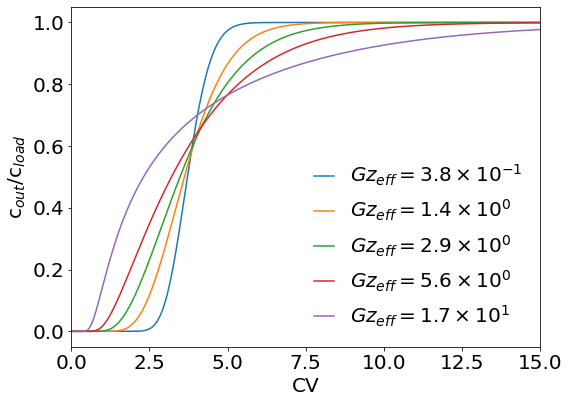

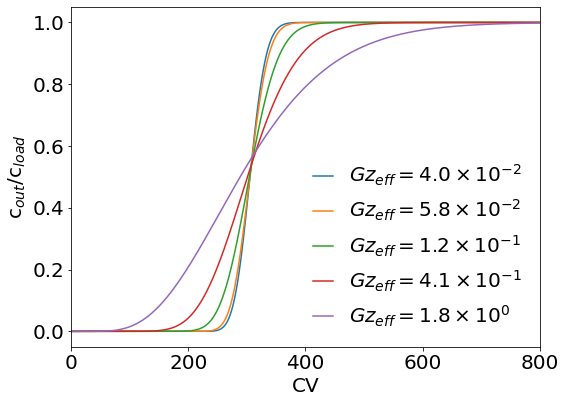

In [122]:
indeces = [20, 30, 40, 50, 65]
gz_1 = [df_params_1.at[i, 'gz'] for i in indeces]
gz_3 = [df_params_1.at[i, 'gz_3'] for i in indeces]

fig, ax = plot_grouped_by_gz(gz_1, res_1)
ax.set_xlim(0, 15)
fig.savefig(os.path.join(image_folder, 'profiles_keq_1_grouped_by_gz.png'), bbox_inches='tight', dpi=300)
fig.savefig(os.path.join(image_folder, 'profiles_keq_1_grouped_by_gz.pdf'), bbox_inches='tight')

fig, ax = plot_grouped_by_gz(gz_3, res_3)
ax.set_xlim(0, 800)
fig.savefig(os.path.join(image_folder, 'profiles_keq_1000_grouped_by_gz.png'), bbox_inches='tight', dpi=300)
fig.savefig(os.path.join(image_folder, 'profiles_keq_1000_grouped_by_gz.pdf'), bbox_inches='tight')


# Comparison with Yamamoto's plot - need to change

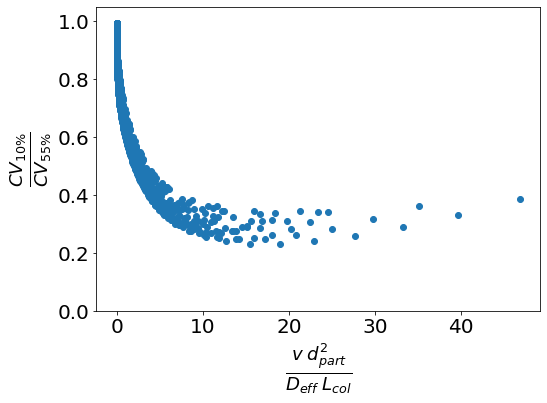

In [166]:
df = pd.read_csv('./updated_discretization_eps_p.csv')

fig, ax = explor.instantiate_fig(8, 6)
ax.set_ylabel(r'$\frac{CV_{10\%}}{CV_{55\%}}$', fontsize=26)
ax.set_xlabel(r'$\frac{v \; d_{part}^2}{D_{eff} \; L_{col}}$', fontsize=26)

ax.plot(df_p['new_x'], df_p['0.10']/df_p['0.55'], 'o')
    
ax.set_ylim(0.0, 1.05)
explor.set_layout(fig, ax)
# fig.savefig('./images_updated_discretization/sharpness_10_55.png', dpi=200)